# Vaccine Bandits 

We consider the problem of identifying optimal strategies for allocating influenza vaccine.
Following~\citep{Libin:2017}, we format this problem as an instance of the BAI where each vaccine allocation strategy is an arm,
and the reward of a strategy is defined as the proportion of individuals that did not experience symptomatic infection.
  We generate 1000 rewards for each strategy by simulating the epidemic for 180 days using (FluTE)[https://github.com/dlchao/FluTE]
  (with basic reproduction number $R0 = 1.3$).
  The $0.5-$quantile (i.e. the median) is more robust to those outliers compared with the mean.
  We consider the task of identifying $m=1$ (optimal arm: No. 9) and $m=3$ (optimal arms: No. 9, 25 and 13) arms with highest $0.5-$quantile values, 
  out of totally $K = 32$ arms with fixed budget.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.BAI_FixedBudget import *
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate
from codes.plots import *

%matplotlib inline

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15
        }

matplotlib.rc('font', **font)

In [2]:
rewards_array = np.load('rewards.npy')
data_type = 'R0_1_dot_3'

# rewards_array = np.load('rewards-R0-1.5.npy')
# data_type = 'RO_1.5'

# rewards_array = np.load('rewards-R0-5.npy')
# data_type = 'RO_5'

# setting
results = defaultdict(dict)
num_exper = 5000
epsilon = 0 # no error
tau = 0.5 # quantile level

# Single best arm identification 
m=1
budget_list = [500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]

# multiple best arms identification
# m = 3
# budget_list = [1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000]

# output/plot setting

output_file = '../Group_Two_Vaccine_' + data_type + '_' + 'm' + str(m) + str(tau)[-1] +'quant_' + str(num_exper) + 'exper_' + str(budget_list[0]) + '_' + str(budget_list[-1]) + '_budget'
# '../Group_Two_Vaccine_R0_5_m3_05quant_budget_500_2500_exper_2000.pickle'
budget_plot_title = 'Group Two Vaccine with '+ str(tau) + ' quantile (m=' + str(m) + ')'

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


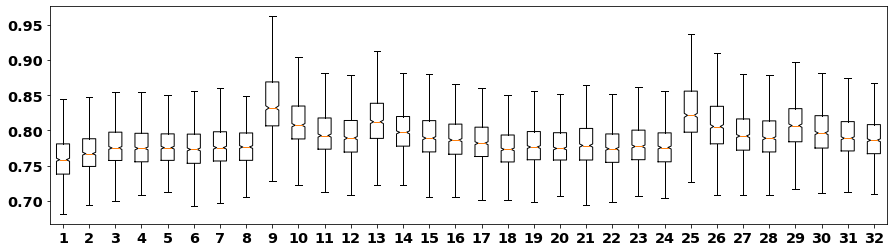

In [3]:
# draw violin plot

plot_array = []
# rewards_array = 1 - rewards_array
for i in rewards_array:
    plot_array.append(list(i))

fig = plt.figure(1, figsize=(15, 4))
ax = fig.add_subplot(111)
b= ax.boxplot(plot_array, meanline=True, sym = 'k+', notch = 1, showfliers=False)

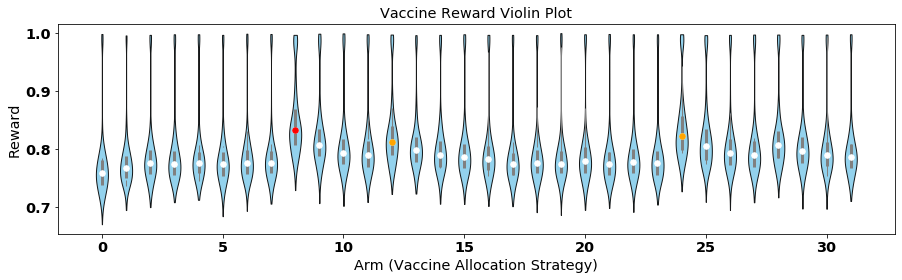

In [11]:
# code from https://matplotlib.org/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(0, len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

quartile1, medians, quartile3 = np.percentile(plot_array, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(plot_array, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.asarray(list(np.arange(0, len(medians))))

fig,  ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 4), sharey=True)

ax2.set_title('Vaccine Reward Violin Plot')
parts = ax2.violinplot(
        plot_array, positions=inds, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.9)

sorted_idx = np.argsort(medians)[::-1]

ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.scatter(inds[sorted_idx[0]], medians[sorted_idx[0]], marker='o', color='red', s=30, zorder=3)
ax2.scatter(inds[np.asarray(sorted_idx[1:3])], medians[np.asarray(sorted_idx[1:3])], marker='o', color='orange', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='grey', linestyle='-', lw=3)
ax2.vlines(inds, whiskers_min, whiskers_max, color='grey', linestyle='-', lw=1)
# ax2.hlines(np.max(medians),0,len(medians), colors='grey', lw=1)
# ax2.hlines(np.sort(medians)[::-1][2],0,len(medians), colors='grey', lw=1)

# set style for the axes
for i in plot_array:
    set_axis_style(ax, list(range(0,32)))

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.xlabel('Arm (Vaccine Allocation Strategy)')
plt.ylabel('Reward')
# plt.show()
plt.savefig('Vaccine_Reward_Violin_Plot.pdf', bbox_inches='tight')

In [12]:
# for i in plot_array:
#     plt.hist(i)

In [15]:
class Vaccine_Env():
    """Env for Exponential Distribution.
    """
    def __init__(self, reward):
        self.reward = reward

    def sample(self, size = None):
        return np.random.choice(self.reward)

    def est_hazard_rate(self,bandwidth = 0.002):
        sorted_reward = np.sort(self.reward)
        x_list = np.arange(sorted_reward[0], sorted_reward[-1], 0.004)
        est_h_list = []
        for i, x in enumerate(x_list):
            count1 = 0
            count2 = 0
            for reward in sorted_reward:
                if x <= reward <= x + bandwidth:
                    count1 +=1
                if x<= reward:
                    count2+=1
            est_h = count1/count2/bandwidth
            est_h_list.append(est_h)

        plt.scatter(x_list, est_h_list)
        plt.title('Hazard Rate Estimation.')
        plt.xlabel('Reward')
        plt.ylabel('Estimate Hazard Rate')

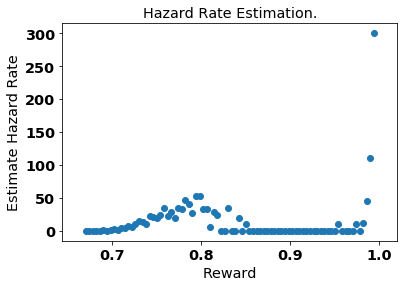

In [16]:
Vaccine_Env(rewards_array[0]).est_hazard_rate()

In [17]:
def setup_env(rewards_array, ss_list = ['quantile_0.5'], random_set = None):
    """Setup environment for Vaccine simulations.
    """
    
    rewards_env = defaultdict(list)
    true_ss_dict = {}

    name = 'vaccine'
    true_ss_dict[name] = defaultdict(list)

    for arm_no, reward in enumerate(rewards_array):
        
        current_env = Vaccine_Env(reward)
                
        rewards_env[name].append(current_env)
                
        for ss in ss_list:
            ss_name = ss.split('_')[0]
            if len(ss.split('_'))> 1:
                ss_para = float(ss.split('_')[-1])
            if ss_name == 'quantile':
                true_ss_dict[name][ss].append(np.quantile(reward, ss_para))
            elif ss_name == 'mean':
                true_ss_dict[name][ss_name].append(np.mean(reward))
            else:
                assert True, 'Unknown summary statistics!'

    return rewards_env, true_ss_dict

In [18]:
rewards_env, true_ss_dict = setup_env(rewards_array, ['quantile_' + str(tau)])
rewards_env_mean, true_ss_dict_mean = setup_env(rewards_array, ['mean'])

In [19]:
np.sort(true_ss_dict['vaccine']['quantile_' + str(tau)])[::-1]

array([0.832    , 0.8215   , 0.812297 , 0.8074905, 0.806895 , 0.8056455,
       0.7973515, 0.7964535, 0.792802 , 0.792104 , 0.789211 , 0.789105 ,
       0.789    , 0.789    , 0.786357 , 0.7861605, 0.782    , 0.778666 ,
       0.7773055, 0.776556 , 0.7765   , 0.775862 , 0.775612 , 0.775612 ,
       0.775225 , 0.7745565, 0.7745   , 0.774    , 0.77317  , 0.773113 ,
       0.767116 , 0.7585   ])

In [20]:
np.sort(true_ss_dict_mean['vaccine']['mean'])[::-1]

array([0.84918235, 0.83842017, 0.82649467, 0.82401163, 0.82287589,
       0.82090716, 0.80957391, 0.80842461, 0.80819587, 0.80547068,
       0.80478267, 0.80392932, 0.80356375, 0.80350546, 0.80088931,
       0.79884064, 0.79764479, 0.79184802, 0.78907015, 0.78882769,
       0.78878722, 0.78803469, 0.78773168, 0.78745381, 0.78729464,
       0.78688506, 0.78663496, 0.78646999, 0.78434754, 0.78349131,
       0.77564602, 0.76802389])

In [12]:
def run_exper(rewards_env, summary_stats, policy, epsilon, m, budget, num_exper, 
              fixed_samples_list = None):
    for key in rewards_env.keys():
        name = key + '_' + str(num_exper)
        policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
        subname = policy_name  + str(budget) 
        p = IntProgress(max = num_exper)
        p.description = 'Running'
        display(p)
        results[name][subname] = []

        result = simulate(rewards_env[key],summary_stats[key], policy, 
                epsilon, m, budget, num_exper, p, fixed_samples_list)
        results[name][subname].append(result)

In [13]:

for budget in budget_list:
    run_exper(rewards_env, true_ss_dict, Q_SR, epsilon, m, budget, num_exper)
    run_exper(rewards_env, true_ss_dict, Q_SAR_Simplified, epsilon, m, budget, num_exper)
    run_exper(rewards_env, true_ss_dict, batch_elimination, epsilon, m, budget, num_exper)
    run_exper(rewards_env, true_ss_dict, uniform_sampling, epsilon, m, budget, num_exper)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  Budget  Probability of Error       std     Policy
0    500                0.1322  0.033871       Q-SR
1    500                0.1270  0.033297      Q-SAR
2    500                0.2494  0.043267       Q-BS
3    500                0.3862  0.048688  Q-Uniform
4    750                0.0706  0.025616       Q-SR


,Budget,Probability of Error,std,Policy
0,500,0.1322,0.033871,Q-SR
1,500,0.1270,0.033297,Q-SAR
2,500,0.2494,0.043267,Q-BS
3,500,0.3862,0.048688,Q-Uniform
4,750,0.0706,0.025616,Q-SR
5,750,0.0782,0.026849,Q-SAR
6,750,0.2554,0.043609,Q-BS
7,750,0.2946,0.045586,Q-Uniform
8,1000,0.0434,0.020376,Q-SR
9,1000,0.0418,0.020013,Q-SAR


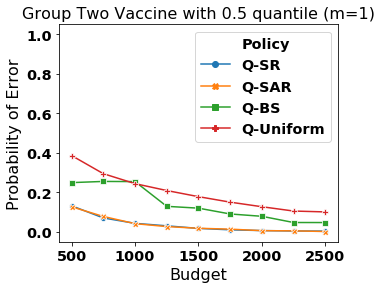

In [15]:
# save results

with open(output_file, 'wb') as handle:
     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('../Group_One_Fixed_Budget.pickle', 'rb') as handle:
#     results = pickle.load(handle)

plot_eva_budget(results, 'pe', paper_flag = True, with_para = True, title = budget_plot_title, log_scale = False)